# BERT for text classification

These notes will show you how to use BERT for text-classification. Some highlights:
* dataloaders in pytorch,
* BERT from pytorch-transformers,
* freezing layers,
* learning rate schedulers, optimizers and gradient clipping,
* mixed precision training,
* logging your training.

Resources:
* [a good tutorial from C. McCormick](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
* [the original BERT paper](https://arxiv.org/abs/1810.04805)
* [the main library we use is pytorch-tranformers from huggingface](https://github.com/huggingface/pytorch-transformers)
* ['Fine-tuning BERT for text classification' by Sun et. al](https://arxiv.org/abs/1905.05583)
* [a post on compressing and speeding-up large models](https://blog.rasa.com/compressing-bert-for-faster-prediction-2/)

## Modules

In [2]:
import torch
from pytorch_transformers import *

import pandas as pd
import numpy as np
import datetime
import pickle, os, shutil

from collections import defaultdict

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange, tqdm_notebook
import io
import matplotlib.pyplot as plt
% matplotlib inline

from apex import amp

## Loading BERT

Various pretrained models are available in pytorch-transformers.

In [3]:
#          Model          | Tokenizer          | Pretrained weights shortcut
MODELS = [(BertModel,       BertTokenizer,      'bert-base-uncased'),
          (OpenAIGPTModel,  OpenAIGPTTokenizer, 'openai-gpt'),
          (GPT2Model,       GPT2Tokenizer,      'gpt2'),
          (TransfoXLModel,  TransfoXLTokenizer, 'transfo-xl-wt103'),
          (XLNetModel,      XLNetTokenizer,     'xlnet-base-cased'),
          (XLMModel,        XLMTokenizer,       'xlm-mlm-enfr-1024'),
          (RobertaModel,    RobertaTokenizer,   'roberta-base')]

... and even BERT has many variations, the first being the base model and the rest are equipped with different heads for different tasks.

In [7]:
BERT_MODEL_CLASSES = [BertModel, BertForPreTraining, BertForMaskedLM, BertForNextSentencePrediction,
                      BertForSequenceClassification, BertForMultipleChoice, BertForTokenClassification,
                      BertForQuestionAnswering]

In [6]:
def loadModelTokenizer(num_labels = 2, language = 'english'):
    model_class = BertForSequenceClassification
    tokenizer_class = BertTokenizer
    if language == 'english':
        pretrained_weights = 'bert-base-uncased'
    if language == 'german':
        pretrained_weights = 'bert-base-german-cased'

    tokenizer = tokenizer_class.from_pretrained(pretrained_weights, do_lower_case=False)
    model = model_class.from_pretrained(pretrained_weights, num_labels)
    return model, tokenizer

In [94]:
model, tokenizer = loadModelTokenizer(4, 'english')

The pre-trained model you are loading is an uncased model but you have set `do_lower_case` to False. We are setting `do_lower_case=True` for you but you may want to check this behavior.


We can pass model to the GPU already:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

### Layers and parameters

Counting model parameters and accessing individual layers is not too bad using the following functions:

In [9]:
def count_parameters(model, trainable_only = True):
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

count_parameters(model)

109483778

In [23]:
def num_layers(model, verbose=False):
    print('Number of layers: {}'.format(len(list(model.children()))))
    if verbose:
        for c in model.children():
            print(str(c)[:50]+'...')

def get_child(model, *arg):
    res = model
    for i in arg:
        res = list(res.children())[i]
    return res

def freeze_model(model):
    for param in model.parameters():
            param.requires_grad = False
            
def unfreeze_model(model):
    for param in model.parameters():
            param.requires_grad = True

In [28]:
num_layers(model, verbose=True)

Number of layers: 3
BertModel(
  (embeddings): BertEmbeddings(
    (wo...
Dropout(p=0.1)...
Linear(in_features=768, out_features=2, bias=True)...


We can go into BERT: it has three main parts, the first being BertEmbeddings. 

In [21]:
b0 = get_child(model, 0, 0)
b0

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1)
)

The main part is the middle: BertEncoder.

In [22]:
b1 = get_child(model, 0, 1)
b1

BertEncoder(
  (layer): ModuleList(
    (0): BertLayer(
      (attention): BertAttention(
        (self): BertSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
      )
      (output): BertOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1)
      )
    )
    (

The latter has 12 layers and a gazillion parameters:

In [25]:
count_parameters(b1)

Number of layers: 1


(None, 85054464)

And finally, a simple BertPooler.

In [26]:
b2 = get_child(model, 0, 2)
b2

BertPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

We will use a custom freezer later that only lets part of BERT train apart from the classifier.

In [29]:
def custom_freezer(model):
    unfreeze_model(model)
    print('All parameters unfreezed: {}'.format(count_parameters(model)))

    ## freeze whole BertLayer
    for c in model.children():
        if str(c).startswith('Bert'):
            freeze_model(c)
            
    ## unfreeze top 3 layer in BertEncoder
    bert_encoder = get_child(model, 0, 1, 0)
    for i in range(1, 4):
        m = bert_encoder[-i] 
        print('Unfreezing: {}'.format(m))
        unfreeze_model(m)
        
    ## unfreeze Pooling layer
    bert_pooling = get_child(model, 0, 2)
    unfreeze_model(bert_pooling)

    print('Trainable parameters: {}'.format(count_parameters(model, True)))
     

In [59]:
custom_freezer(model)

All parameters unfreezed: 109483778
Unfreezing: BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1)
  )
)
Unfreezing: BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      

## Data

In [3]:
## put the train and text csv to PATH
DATA_PATH = '...'

def read_AGNews(DATA_PATH):
    train_df = pd.read_csv(DATA_PATH+'train.csv', header=None)
    train_df.rename(columns={0: 'label',1: 'title', 2:'text'}, inplace=True)
    train_df = pd.concat([train_df, pd.get_dummies(train_df['label'],prefix='label')], axis=1)
    
    test_df = pd.read_csv(DATA_PATH+'test.csv', header=None)
    test_df.rename(columns={0: 'label',1: 'title', 2:'text'}, inplace=True)
    test_df = pd.concat([test_df, pd.get_dummies(test_df['label'],prefix='label')], axis=1)
    return train_df, test_df

train_df, test_df = read_AGNews(DATA_PATH)

In [4]:
train_df.head()

,label,title,text,label_1,label_2,label_3,label_4
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",0,0,1,0
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,0,0,1,0
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,0,0,1,0
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,0,0,1,0
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",0,0,1,0


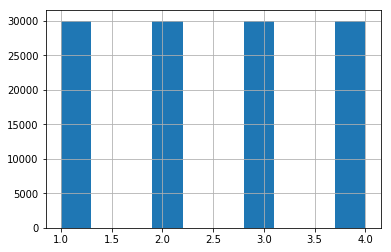

In [34]:
train_df.label.hist()

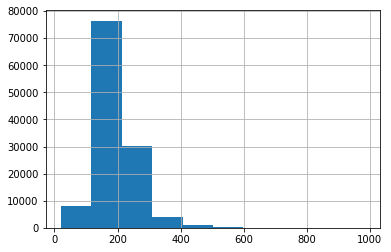

In [5]:
train_df.text.apply(lambda x: len(x)).hist()

The document lengths will be important in a second.

### Encoding the text for BERT

We need to do the following:
* apply the pre-trained sub-word tokenizer that comes with BERT,
* append special tokens for classification at the beginning and end of each sample,
* make sure that each sample sequence of tokens has length at most 512 (that's the max input length for BERT).

We will pad everything to uniform length to make life easier (torch.tensor will throw errors otherwise at later steps).

In [38]:
## tokenizer.encode() will do the tokenization and converting into subword IDs in a single step

tokenizer.encode('a dog is not a table')

[3899, 2795]

In [39]:
## cutting and padding
def padSentenceForBert(sent, cls_id, sep_id, lg):
    return [cls_id]+sent[:lg-2]+[sep_id] + [0]*(lg - len(sent[:lg-2])-2) 
        
def padAndTokenizeForBert(sentences, lg):
    cls_id = tokenizer.convert_tokens_to_ids(tokenizer.cls_token)
    sep_id = tokenizer.convert_tokens_to_ids(tokenizer.sep_token)
    return [padSentenceForBert(tokenizer.encode(sent), cls_id, sep_id, lg) for sent in tqdm_notebook(sentences)]

In [48]:
train_ids = padAndTokenizeForBert(train_df.text, 512) 

In [49]:
test_ids = padAndTokenizeForBert(test_df.text, 512)

Be careful, the **labels need to be from 0 to number_of_classes**. In our case, this is simply done:

In [50]:
train_labels = train_df.label.values - 1
test_labels = test_df.label.values - 1

#### Masks

We want to make sure that the model ignores the padding, so we define masks that will be fed to the BERT model as well (1 stands for a real token and 0 for padding coordinates).

In [44]:
def masker(input_ids):
    return [[float(i>0) for i in seq] for seq in input_ids]


In [51]:
train_mask = masker(train_ids)
test_mask = masker(test_ids)


#### Validation split for training data and masks together

In [52]:
SPLIT_RATIO = 0.1
train_ids, val_ids, train_labels, val_labels, train_mask, val_mask = train_test_split(train_ids, train_labels, train_mask,  
                                                                                random_state=42, test_size=SPLIT_RATIO)

In [54]:
len(train_ids), len(train_labels), len(train_mask), len(val_ids), len(val_labels), len(val_mask)

(108000, 108000, 108000, 12000, 12000, 12000)

### Feeding the data to BERT

Pytorch has great dataset and dataloader classes that make life easier, especially when the data does not fit into memory. At the same time we construct the loader, we start turning our id sequences to tensors.

In [82]:
BATCH_SIZE = 32

def loader(ids, mask, labels, mode = 'random'):
    ids = torch.tensor(ids)
    mask = torch.tensor(mask)
    labels = torch.tensor(labels)
    train_data = TensorDataset(ids, mask, labels)
    if mode == 'random': 
        train_sampler = RandomSampler(train_data)
    else:
        train_sampler = SequentialSampler(train_data)
    return DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

In [83]:
train_loader = loader(train_ids, train_mask, train_labels)
val_loader = loader(val_ids, val_mask, val_labels, mode = None)

You can look inside these data loaders as follows:

In [84]:
batch = next(iter(train_loader))

In [86]:
ids, mask, label = batch

In [88]:
ids.size(), mask.size(), label.size()

(torch.Size([32, 512]), torch.Size([32, 512]), torch.Size([32]))

You can see the batch of 32 samples, each of length 512.

# Training BERT

## Metrics and logging

The BERT sequence classifier outputs logits which need to be turned into probabilities (softmax) before fed into the metrics. 

In [60]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score

## alternatively: from scipy.special import softmax

def softmax(logits):
    return np.array([a/b for a,b in zip(np.exp(logits), np.sum(np.exp(logits), axis=1))])

def softmax_accuracy(labels, logits):
    preds = np.argmax(softmax(logits), axis=1)
    return accuracy_score(labels, preds)

def softmax_rocauc(labels, logits):
    preds = np.argmax(softmax(logits), axis=1)
    return roc_auc_score(labels, preds)

def save_checkpoint(state, is_best, logdir = ''):
    statefilename = logdir+'last_checkpoint.pt'
    torch.save(state, statefilename)
    if is_best:
        shutil.copyfile(statefilename, logdir+'model_best.pt')

def eval_metrics(metrics, labels, preds):
    result = dict()
    for name, metric in metrics.items():
        result[name] = metric(labels, preds)
    return result


## Training

We will have a train-method which takes the model, optimizer and learning rate scheduler with a hyperparameter dictionary.

In [90]:
params = dict()
params['epochs'] = 4
params['max_grad'] = 1
params['base_lr'] = 1e-3
params['metrics'] = {'accuracy': softmax_accuracy, 'roc_auc': softmax_rocauc}

## where to save the models (they can take a few Gb if all the params are training)
LOG_PATH = '...'

params['logdir'] = LOG_PATH + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"/"

params['train_dataloader'] = train_loader
params['val_dataloader'] = val_loader

num_total_steps = params['epochs']*len(params['train_dataloader'])
warmup_proportion = 0.1
num_warmup_steps = int(num_total_steps*warmup_proportion)
    
optimizer = AdamW(model.parameters(), lr=params['base_lr'], correct_bias=False) 
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps) 

Now the train-method that I still need to modularize:
* we set the model and opt. to mixed precision for faster training,
* the main for-loop goes over the epochs:
    * first, we loop over each batch, calculate the loss and back propagate,
    * second, we evaluate the model on the validation set with respect to our metrics,
    * last, we save the current model and update the best_model (if needed).
    
The method will return the history dictionary (much like Keras) with a bunch of nice metrics we can visualize.     


In [91]:
def train(mops, params, do_amp = True, test_mode=False, warm = False):
    
    model, optimizer, scheduler = mops
    print('Trainable params in the model: {}\n'.format(count_parameters(model)))
    
    ## metrics and logging
    metrics = params['metrics']
    os.makedirs(params['logdir'], exist_ok=True)
    history = defaultdict(list)
    
  
    ## If new training started we reset the mixed-precision training:
    if not warm and do_amp:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O2", 
                                              keep_batchnorm_fp32=True, loss_scale="dynamic")


    for epoch in range(params['epochs']):
        print("Epoch {}:".format(epoch+1))
        ## set training mode!
        model.train()

        ## Tracking loss during the epoch
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        ## Train the data for one epoch

        for batch in tqdm_notebook(params['train_dataloader']):
            
            ## Add batch to GPU and unpack
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            ## Clear out the gradients (by default they accumulate) and forward pass
            optimizer.zero_grad()
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, 
                           labels=b_labels)
            loss = output[0]

            ## Backward pass
            if do_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            ## Update parameters and clip

            optimizer.step()
            scheduler.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), params['max_grad'])  


            ## logging
            history['train_loss_per_batch'].append(loss.item()) 

            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1
            
            ## for testing, break early
            if test_mode and nb_tr_steps > 20:
                break
        
        ## logging
        history['train_loss_per_epoch'].append(tr_loss/nb_tr_steps)
        
        print("Train loss: {}".format(history['train_loss_per_epoch'][-1]))

        
        print('Validation...')

        val_labels, val_logits = testEval(model, params['val_dataloader'], test_mode = test_mode)
    
        for name, metric in metrics.items():
            m = metric(val_labels, val_logits)
            history['val_'+name].append(m)
            print("Validation {}: {}".format(name, m))
        
        ## Saving the history file if training is interrupted early
        with open(logdir+'history.pk', 'wb') as f:
            f.truncate(0)
            pickle.dump(history, f)
                
        ## Saving best (wrt monitored quantity) and also the last model 
        monitored = history['val_accuracy']
        best_value = max(monitored)
        last_value = monitored[-1]
        is_last_best = last_value == best_value
        
        save_checkpoint({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'best_kpi': best_value,
            'loss': history['train_loss_per_epoch'][-1],
            #'params': params
        }, is_last_best, logdir)
   
    return history

def testEval(model, dataloader, test_mode=False):
    ## eval mode!
    model.eval()

    nb_eval_steps = 0

    val_logits = []
    val_labels = []

    for batch in tqdm_notebook(dataloader):
        ## Add batch to GPU and unpack
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        ## not calculating the gradients speeds up inference a lot
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        ## logits and labels to CPU
        logits = logits[0].detach().cpu().tolist()
        label_ids = b_labels.to('cpu').tolist()

        val_logits += logits
        val_labels += label_ids
        nb_eval_steps += 1

        ## if testing break early
        if test_mode and nb_eval_steps > 20:
            break   
            
    return val_labels, val_logits


In [93]:
history = train((model, optimizer, scheduler), params, test_mode=True)

Trainable params in the model: 21855746

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


RuntimeError: Found param bert.embeddings.word_embeddings.weight with type torch.cuda.HalfTensor, expected torch.cuda.FloatTensor.
When using amp.initialize, you do not need to call .half() on your model
before passing it, no matter what optimization level you choose.

Remarks about the hyper-parameters:
* try out different learning rate schedules (cyclic works best a lot of times) but be careful about large values and catastrophic forgetting;
* freeze and unfreeze layers, and adapt the learning rate to decrease on lower layers;
* the recommended batch size for BERT fine-tuning is 16 or 32 (memory is also a big issue);
* the model should be done in 4-6 epoch usually.

## Visualizing the training metrics

In [ ]:
def draw_history(history, metrics):
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(history['train_loss_per_batch'])
    plt.show()

    plt.title("Train loss and val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Acc")
    for name in metrics.keys():
        plt.plot(history['val_'+name])
    plt.legend(['Train loss']+ [name for name in metrics.keys()])
    plt.show()
    
draw_history(history)

# Test scores

Finally, (finding the best hyper parameters and retraining the model a dozen times) we can reload the best model and evaluate on the test set.

In [ ]:
model, _ = loadModelTokenizer(4, 'english')

In [ ]:
PATH = ...

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])


In [ ]:
test_loader = loader(test_ids, test_mask, test_labels)

labels, logits = testEval(model, test_loader)

metrics = {'accuracy': softmax_accuracy, 'roc_auc': softmax_rocauc}

for name, metric in metrics.items():
    m = metric(val_labels, val_logits)
    print("Test {}: {}".format(name, m))